In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

import stan
import arviz as az

import nest_asyncio
nest_asyncio.apply()

### Parameters and Model

The 1HT MPT model is depicted in the following figure:

<img src="1HTMPT.png" width=65% height=65% />


The table below lists the two latent parameters and corresponding interpretations:


| Parameter | Description |
| --- | --- |
| $d$ | Probability of recognizing a word in the second set of words | 
| $g$ | Probability of guessing that a word was seen in the old list  |

The table below lists the four types of responses (categories):


| Response (Category) | Description  | Probability |
| --- | --- | --- |
| True Positive | The response was "old" and the word is old | $0.5(d + (1-d)\times g)$ |
| False Positive | The response was "old" but the word is new | $0.5g$ |
| True Negative | The response was "new" and the word is new | $0.5(1-g)$ |
| False Negative | The response was "new" and the word is old  | $0.5((1-d)\times(1-g))$ |

### Simulating the Model

Practice: We first need to derive the equations for the category probabilities according to the graphical model.

In [8]:
data=[7,1,9,3]

In [9]:
data

[7, 1, 9, 3]

In [21]:
mpt_model_code = """
data {
  int<lower=1> N; // Number of trials
  int<lower=1> K; // Number of categories
  array[K] int<lower=0, upper=N> freqs;
}

parameters {
  real<lower = 0, upper=1> d;
  real<lower = 0, upper=1> g;
}

transformed parameters {
  // Model equations go here
  // Prob. True Positive
  // Prob. False Positive
  // Prob. True Negative
  // Prob. False Negative
  simplex[4] theta;
  theta[1] = 0.5*(d+(1-d)*g);
  theta[2] = 0.5*g;
  theta[3] = 0.5*(1-g);
  theta[4] = 0.5*(1-d)*(1-g);
}

model {
  target+=beta_lpdf(d| 1,1);
  target+=beta_lpdf(g | 1,1);
  target+=multinomial_lpmf(freqs | theta);
}

generated quantities{
  array[K] int pred_freqs;
  pred_freqs = multinomial_rng(theta, N);
}
"""

In [22]:
### Compile, fit, and diagnose model
### Your code here
stan_dict = {
    'freqs': data,
    'N': 20,
    'K': 4
}

# Compile model
posterior = stan.build(mpt_model_code, data=stan_dict, random_seed=42)


# Sample (i.e., inverse inference)
fit = posterior.sample(num_chains=4, num_samples=2500, num_warmup=1000)

Building: 0.1s
Building: 0.2s
Building: 0.3s
Building: 0.4s
Building: 0.5s
Building: 0.6s
Building: 0.7s
Building: 0.8s
Building: 0.9s
Building: 1.0s
Building: 1.1s
Building: 1.2s
Building: 1.3s
Building: 1.4s
Building: 1.5s
Building: 1.6s
Building: 1.8s
Building: 1.9s
Building: 2.0s
Building: 2.1s
Building: 2.2s
Building: 2.3s
Building: 2.4s
Building: 2.5s
Building: 2.6s
Building: 2.7s
Building: 2.8s
Building: 2.9s
Building: 3.0s
Building: 3.1s
Building: 3.2s
Building: 3.3s
Building: 3.4s
Building: 3.5s
Building: 3.6s
Building: 3.7s
Building: 3.8s
Building: 3.9s
Building: 4.0s
Building: 4.1s
Building: 4.2s
Building: 4.3s
Building: 4.4s
Building: 4.5s
Building: 4.6s
Building: 4.7s
Building: 4.8s
Building: 4.9s
Building: 5.0s
Building: 5.1s
Building: 5.3s
Building: 5.4s
Building: 5.5s
Building: 5.6s
Building: 5.7s
Building: 5.8s
Building: 5.9s
Building: 6.0s
Building: 6.1s
Building: 6.2s
Building: 6.3s
Building: 6.4s
Building: 6.5s
Building: 6.6s
Building: 6.7s
Building: 6.8s
Building: 

Building: 16.0s, done.
Sampling:   0%
Sampling:  25% (3500/14000)
Sampling:  50% (7000/14000)
Sampling:  75% (10500/14000)
Sampling: 100% (14000/14000)
Sampling: 100% (14000/14000), done.
Messages received during sampling:
  Gradient evaluation took 6e-06 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.06 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 6e-06 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.06 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 6e-06 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.06 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 7e-06 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.07 seconds.
  Adjust your expectations accordingly!


In [23]:
### Parameter recovery and predictions
# Estimation summary, convergence, and efficiency diagnostics
az.summary(fit)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
d,0.587,0.171,0.257,0.877,0.002,0.002,5637.0,4301.0,1.0
g,0.181,0.108,0.015,0.385,0.001,0.001,4952.0,4099.0,1.0
theta[0],0.334,0.065,0.211,0.448,0.001,0.001,7438.0,6508.0,1.0
theta[1],0.091,0.054,0.007,0.193,0.001,0.001,4952.0,4099.0,1.0
theta[2],0.409,0.054,0.307,0.493,0.001,0.001,4952.0,4099.0,1.0
theta[3],0.166,0.065,0.052,0.289,0.001,0.001,7438.0,6508.0,1.0
pred_freqs[0],6.687,2.462,2.000,11.000,0.026,0.019,8766.0,9289.0,1.0
pred_freqs[1],1.818,1.654,0.000,5.000,0.019,0.014,7067.0,7044.0,1.0
pred_freqs[2],8.166,2.468,3.000,12.000,0.026,0.019,8790.0,9113.0,1.0
pred_freqs[3],3.329,2.095,0.000,7.000,0.023,0.016,8653.0,9183.0,1.0


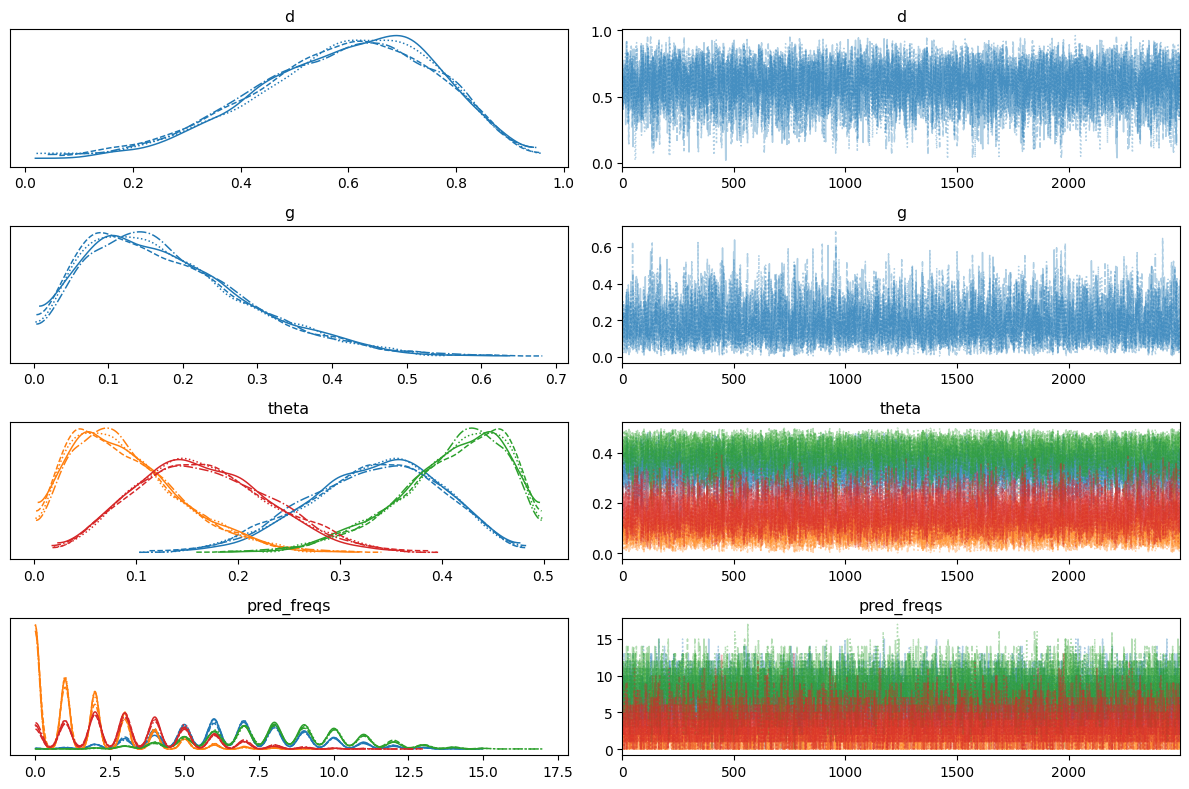

In [24]:
# Traceplots and marginals - visual convergence checks
azarr = az.plot_trace(fit)
plt.tight_layout()

### Parameters and Model

The 2HT MPT model is depicted in the following figure:

<img src="2HTMPT.png" width=65% height=65% />


The table below lists the two latent parameters and corresponding interpretations:


| Parameter | Description |
| --- | --- |
| $d$ | Probability of recognizing a word in the second set of words | 
| $g$ | Probability of guessing that a word was seen in the old list  |

The table below lists the four types of responses (categories):


| Response (Category) | Description  | Probability |
| --- | --- | --- |
| True Positive | The response was "old" and the word is old | $0.5(d + (1-d)\times g)$ |
| False Positive | The response was "old" but the word is new | $0.5((1-d)\times g)$ |
| True Negative | The response was "new" and the word is new | $0.5(d+(1-d)\times(1-g))$ |
| False Negative | The response was "new" and the word is old  | $0.5((1-d)\times(1-g))$ |

In [26]:
ht2_mpt_model_code = """
data {
  int<lower=1> N; // Number of trials
  int<lower=1> K; // Number of categories
  array[K] int<lower=0, upper=N> freqs;
}

parameters {
  real<lower = 0, upper=1> d;
  real<lower = 0, upper=1> g;
}

transformed parameters {
  // Model equations go here
  // Prob. True Positive
  // Prob. False Positive
  // Prob. True Negative
  // Prob. False Negative
  simplex[4] theta;
  theta[1] = 0.5*(d+(1-d)*g);
  theta[2] = 0.5*((1-d)*g);
  theta[3] = 0.5*(d+(1-d)*(1-g));
  theta[4] = 0.5*((1-d)*(1-g));
}

model {
  target+=beta_lpdf(d| 1,1);
  target+=beta_lpdf(g | 1,1);
  target+=multinomial_lpmf(freqs | theta);
}

generated quantities{
  array[K] int pred_freqs;
  pred_freqs = multinomial_rng(theta, N);
}
"""

In [27]:
### Compile, fit, and diagnose model
### Your code here
stan_dict = {
    'freqs': data,
    'N': 20,
    'K': 4
}

# Compile model
ht2_posterior = stan.build(ht2_mpt_model_code, data=stan_dict, random_seed=42)


# Sample (i.e., inverse inference)
ht2_fit = ht2_posterior.sample(num_chains=4, num_samples=2500, num_warmup=1000)

Building: 0.1s
Building: 0.2s
Building: 0.3s
Building: 0.4s
Building: 0.5s
Building: 0.6s
Building: 0.7s
Building: 0.8s
Building: 0.9s
Building: 1.0s
Building: 1.1s
Building: 1.2s
Building: 1.3s
Building: 1.4s
Building: 1.5s
Building: 1.7s
Building: 1.8s
Building: 1.9s
Building: 2.0s
Building: 2.1s
Building: 2.2s
Building: 2.3s
Building: 2.4s
Building: 2.5s
Building: 2.6s
Building: 2.7s
Building: 2.8s
Building: 2.9s
Building: 3.0s
Building: 3.1s
Building: 3.2s
Building: 3.3s
Building: 3.4s
Building: 3.5s
Building: 3.6s
Building: 3.7s
Building: 3.8s
Building: 3.9s
Building: 4.0s
Building: 4.1s
Building: 4.2s
Building: 4.3s
Building: 4.4s
Building: 4.5s
Building: 4.6s
Building: 4.7s
Building: 4.8s
Building: 4.9s
Building: 5.0s
Building: 5.2s
Building: 5.3s
Building: 5.4s
Building: 5.5s
Building: 5.6s
Building: 5.7s
Building: 5.8s
Building: 5.9s
Building: 6.0s
Building: 6.1s
Building: 6.2s
Building: 6.3s
Building: 6.4s
Building: 6.5s
Building: 6.6s
Building: 6.7s
Building: 6.8s
Building: 

Building: 16.1s, done.
Sampling:   0%
Sampling:  25% (3500/14000)
Sampling:  50% (7000/14000)
Sampling:  75% (10500/14000)
Sampling: 100% (14000/14000)
Sampling: 100% (14000/14000), done.
Messages received during sampling:
  Gradient evaluation took 5e-06 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.05 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 3e-06 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.03 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 4e-06 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.04 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 3e-06 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.03 seconds.
  Adjust your expectations accordingly!


In [28]:
### Parameter recovery and predictions
# Estimation summary, convergence, and efficiency diagnostics
az.summary(ht2_fit)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
d,0.562,0.162,0.263,0.856,0.002,0.001,6471.0,4491.0,1.0
g,0.326,0.163,0.042,0.622,0.002,0.001,5901.0,4324.0,1.0
theta[0],0.353,0.064,0.232,0.462,0.001,0.001,6880.0,6001.0,1.0
theta[1],0.072,0.047,0.003,0.157,0.001,0.000,5680.0,4926.0,1.0
theta[2],0.428,0.047,0.343,0.497,0.001,0.000,5680.0,4926.0,1.0
theta[3],0.147,0.064,0.038,0.268,0.001,0.001,6880.0,6001.0,1.0
pred_freqs[0],7.065,2.450,2.000,11.000,0.027,0.019,8366.0,8596.0,1.0
pred_freqs[1],1.444,1.488,0.000,4.000,0.016,0.012,8291.0,8494.0,1.0
pred_freqs[2],8.557,2.407,3.000,12.000,0.025,0.018,9207.0,9234.0,1.0
pred_freqs[3],2.933,1.986,0.000,6.000,0.021,0.015,8617.0,8586.0,1.0


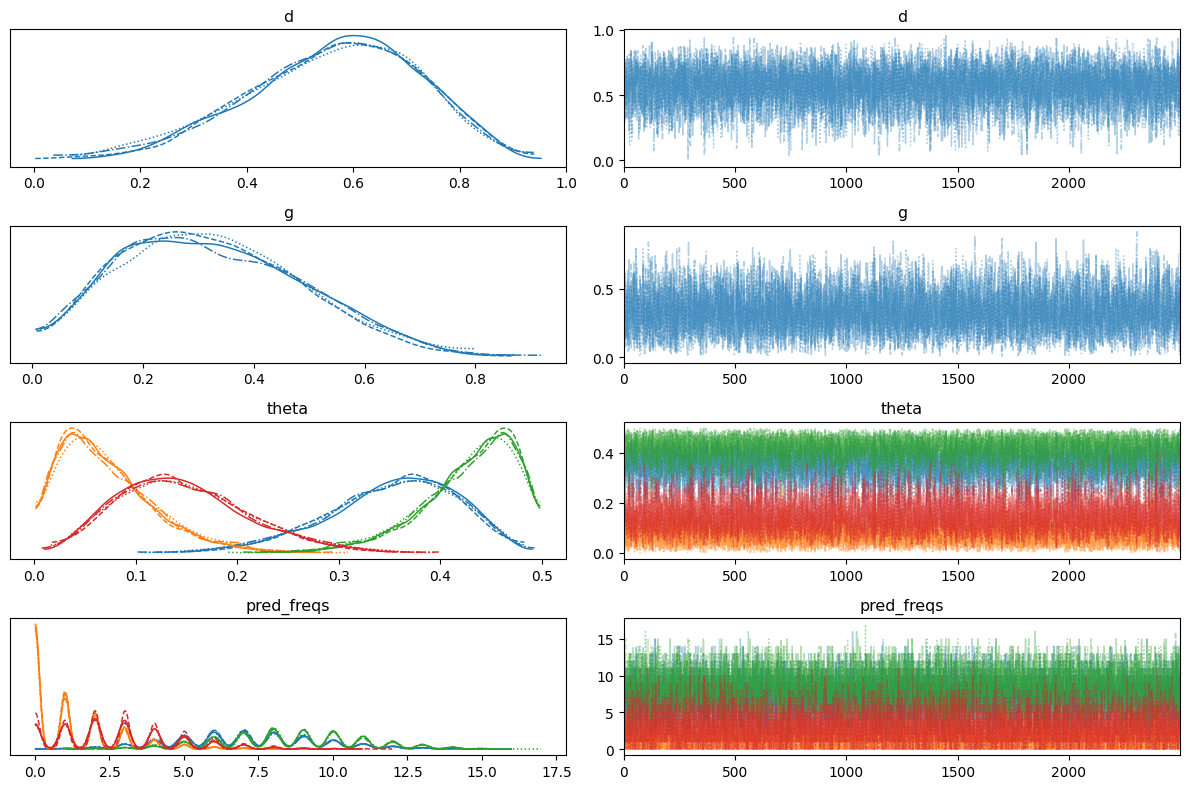

In [29]:
# Traceplots and marginals - visual convergence checks
azarr = az.plot_trace(ht2_fit)
plt.tight_layout()